# Normalizing flow

In [119]:
import normflows as nf 
import torch.optim as optim
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
K = 64 #Number of flows (layers)
torch.manual_seed(0)

latent_size = 2
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(K):
    s = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]

target = nf.distributions.TwoModes(2, 0.1)
q0 = nf.distributions.DiagGaussian(2)

# If the target density is not given
nfm = nf.NormalizingFlow(q0, flows)

# If the target density is given
target = nf.distributions.target.TwoMoons()


# Initialize ActNorm
z, _ = nfm.sample(num_samples=2 ** 7)
z_np = z.to('cpu').data.numpy()
# plt.figure(figsize=(8, 8))
# plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (200, 200), range=[[-3, 3], [-3, 3]])
# plt.gca().set_aspect('equal', 'box')
# plt.show()


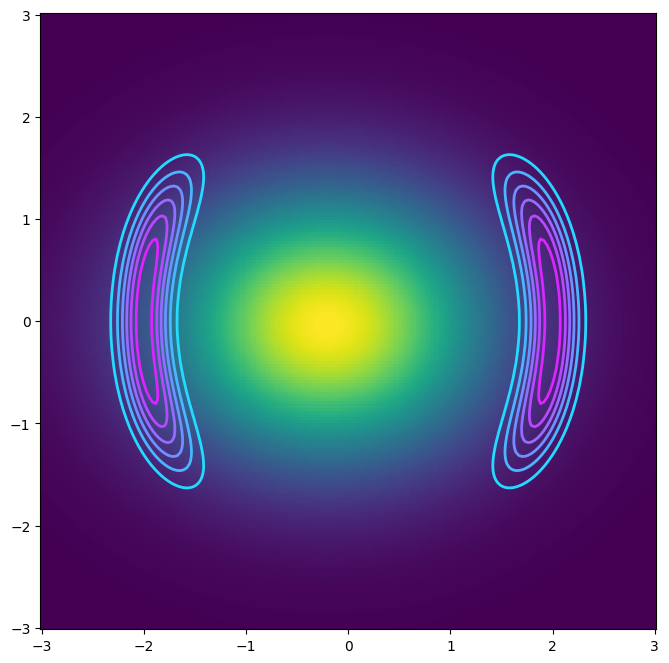

In [121]:

# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob_target = torch.exp(log_prob)

# Plot initial posterior distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_target.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()


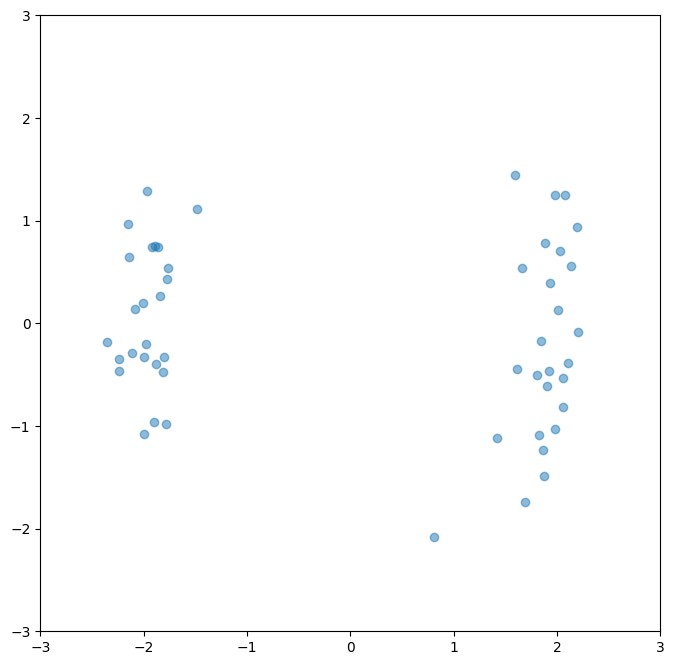

In [122]:
num_samples = 50

x_1 = target.sample(num_samples=num_samples)
plt.figure(figsize=(8, 8))
plt.scatter(x_1[:, 0], x_1[:, 1], alpha=0.5)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [ ]:
# Train model
max_iter = 20000

loss_hist = np.array([])
 
optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-4, weight_decay=1e-6)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    loss = nfm.forward_kld(x_1)
    
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

100%|██████████| 100000/100000 [13:47<00:00, 120.86it/s]


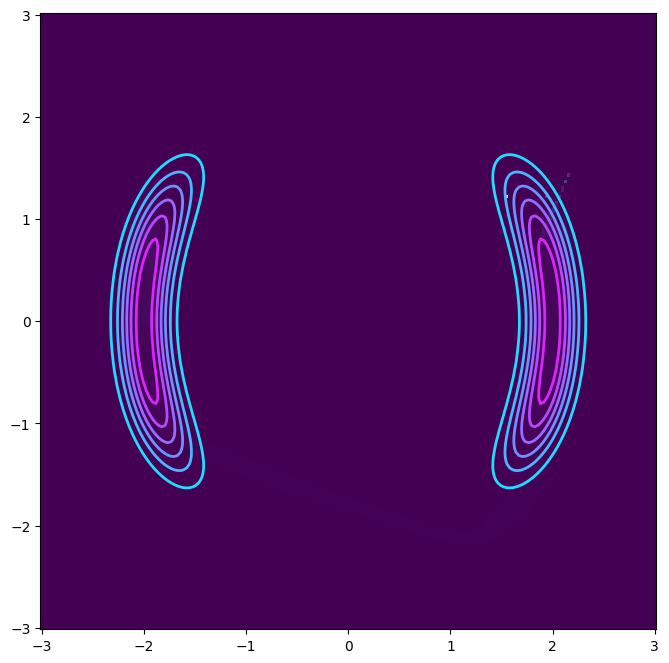

In [ ]:

# Plot learned posterior distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_target.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

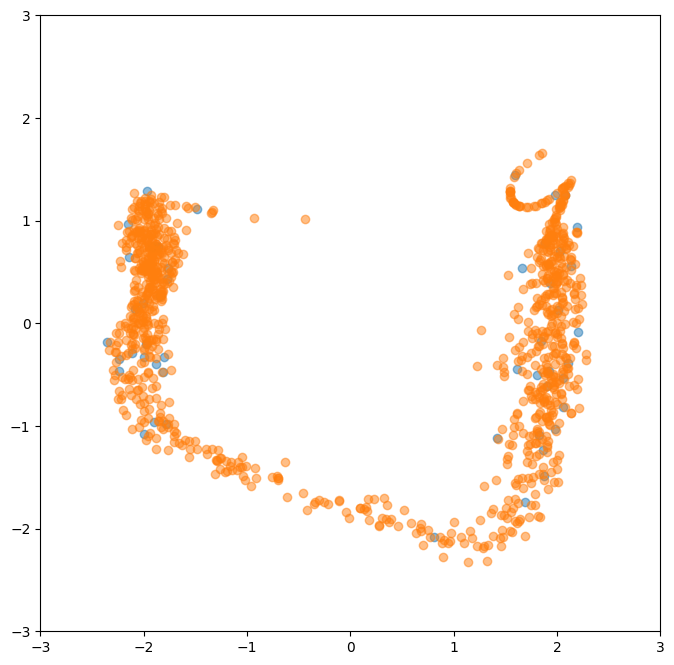

In [140]:
x_0 = nfm.sample(num_samples=1000)[0].detach().numpy()

plt.figure(figsize=(8, 8))
plt.scatter(x_1[:, 0], x_1[:, 1], alpha=0.5)
plt.scatter(x_0[:, 0], x_0[:, 1], alpha=0.5)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

# Flow matching

In [132]:
import flow_matching as fm
from torch import nn, Tensor
import time 
import math
import tqdm

from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

In [133]:
# # Activation class
# class Swish(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, x: Tensor) -> Tensor: 
#         return torch.sigmoid(x) * x

# # Model class
# class MLP(nn.Module):
#     def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
#         super().__init__()
        
#         self.input_dim = input_dim
#         self.time_dim = time_dim
#         self.hidden_dim = hidden_dim

#         self.main = nn.Sequential(
#             nn.Linear(input_dim+time_dim, hidden_dim),
#             Swish(),
#             nn.Linear(hidden_dim, hidden_dim),
#             Swish(),
#             nn.Linear(hidden_dim, hidden_dim),
#             Swish(),
#             nn.Linear(hidden_dim, hidden_dim),
#             Swish(),
#             nn.Linear(hidden_dim, input_dim),
#             )
    

#     def forward(self, x: Tensor, t: Tensor) -> Tensor:
#         sz = x.size()
#         x = x.reshape(-1, self.input_dim)
#         t = t.reshape(-1, self.time_dim).float()

#         t = t.reshape(-1, 1).expand(x.shape[0], 1)
#         h = torch.cat([x, t], dim=1)
#         output = self.main(h)
        
#         return output.reshape(*sz)


#From https://www.youtube.com/watch?v=7cMzfkWFWhI
class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero pad
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        x = x + t 
        x = self.blocks(x)
        x = self.out_projection(x)
        return x

In [134]:
model = MLP(layers=5, channels=512)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [136]:
# # training arguments
# lr = 0.001
# batch_size = 4096
# iterations = 20001
# print_every = 2000 
# hidden_dim = 512

# # velocity field model init
# vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device) 

# # instantiate an affine path object
# path = AffineProbPath(scheduler=CondOTScheduler())

# # init optimizer
# optim = torch.optim.Adam(vf.parameters(), lr=lr) 

# # train
# start_time = time.time()
# for i in range(iterations):
#     optim.zero_grad() 

#     # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
#     x_1 = inf_train_gen(batch_size=batch_size, device=device) # sample data
#     x_0 = torch.randn_like(x_1).to(device)

#     # sample time (user's responsibility)
#     t = torch.rand(x_1.shape[0]).to(device) 

#     # sample probability path
#     path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

#     # flow matching l2 loss
#     loss = torch.pow( vf(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 

#     # optimizer step
#     loss.backward() # backward
#     optim.step() # update
    
#     # log loss
#     if (i+1) % print_every == 0:
#         elapsed = time.time() - start_time
#         print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} ' 
#               .format(i+1, elapsed*1000/print_every, loss.item())) 
#         start_time = time.time()




data = torch.Tensor(x_1)
training_steps = 10000
batch_size = 16
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar:
    x1 = data[torch.randint(data.size(0), (batch_size,))]
    x0 = torch.randn_like(x1)
    target = x1 - x0
    t = torch.rand(x1.size(0))
    xt = (1 - t[:, None]) * x0 + t[:, None] * x1
    pred = model(xt, t)  # also add t here
    loss = ((target - pred)**2).mean()
    loss.backward()
    optim.step()
    optim.zero_grad()
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())

100%|██████████| 10000/10000 [02:22<00:00, 70.17it/s, loss=3.19]


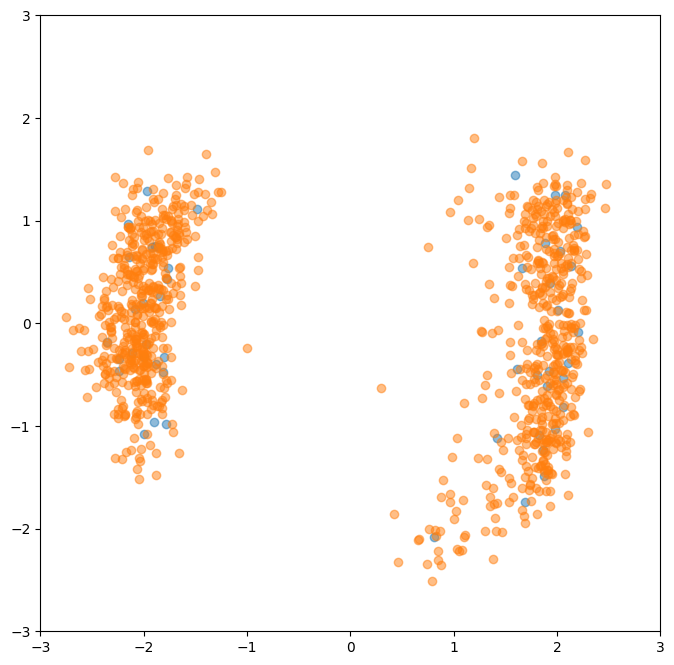

Done Sampling


In [137]:
torch.manual_seed(42)
model.eval().requires_grad_(False)
x_t = torch.randn(1000, 2)
steps = 1000
for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
    pred = model(x_t, t.expand(x_t.size(0)))
    x_t = x_t + (1 / steps) * pred

plt.figure(figsize=(8, 8))
plt.scatter(x_1[:, 0], x_1[:, 1], alpha=0.5)
plt.scatter(x_t[:, 0], x_t[:, 1], alpha=0.5)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

model.train().requires_grad_(True)
print("Done Sampling")

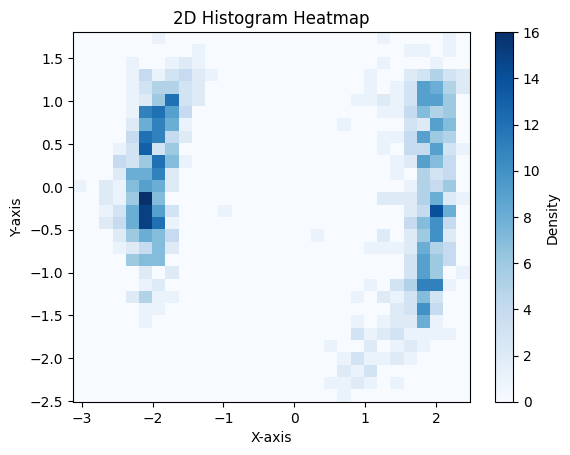

In [139]:
plt.hist2d(x_t[:,0], x_t[:,1], bins=30, cmap='Blues')
plt.colorbar(label='Density')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Histogram Heatmap')
plt.show()